![Colegio Bourbaki](./Images/Bourbaki.png)

# Machine Learning

## Introducción a Redes Neuronales

### Librerias

In [4]:
#Data Analysis
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Neural Network Architecture
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#Metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve

#Utils
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torchsummary import summary

### Funciones de ayuda

In [5]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="g")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()

### Carga de datos

Información sobre el conjunto de datos

Esta base de datos contiene 76 atributos, pero todos los experimentos publicados hacen referencia al uso de un subconjunto de 14 de ellos.  En concreto, la base de datos Cleveland es la única que han utilizado los investigadores de ML hasta la fecha.  El campo "meta" se refiere a la presencia de cardiopatía en el paciente.  Tiene un valor entero de 0 (sin presencia) a 4. Los experimentos con la base de datos Cleveland se han centrado simplemente en intentar distinguir la presencia (valores 1,2,3,4) de la ausencia (valor 0).  
   
Recientemente se han eliminado de la base de datos los nombres y números de la seguridad social de los pacientes, sustituyéndolos por valores ficticios.

Se ha "procesado" un fichero, el que contiene la base de datos de Cleveland.  Los cuatro ficheros no procesados también existen en este directorio.

Para conocer más sobre el dataset pueden ver los siguientes links:

* https://github.com/uci-ml-repo/ucimlrepo

* https://archive.ics.uci.edu/dataset/45/heart+disease

* https://pubmed.ncbi.nlm.nih.gov/2756873/

In [6]:
df = pd.read_csv('./Data/data.csv') #

In [7]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


| Variable Name | Role     | Type         | Demographic | Description                                      | Units  | Missing Values |
|---------------|----------|--------------|-------------|--------------------------------------------------|--------|----------------|
| age           | Feature  | Integer      | Age         |                                                  | years  | no             |
| sex           | Feature  | Categorical  | Sex         |                                                  |        | no             |
| cp            | Feature  | Categorical  |             |                                                  |        | no             |
| trestbps      | Feature  | Integer      |             | resting blood pressure (on admission to the hospital) | mm Hg | no             |
| chol          | Feature  | Integer      |             | serum cholestoral                                | mg/dl  | no             |
| fbs           | Feature  | Categorical  |             | fasting blood sugar > 120 mg/dl                  |        | no             |
| restecg       | Feature  | Categorical  |             |                                                  |        | no             |
| thalach       | Feature  | Integer      |             | maximum heart rate achieved                      |        | no             |
| exang         | Feature  | Categorical  |             | exercise induced angina                          |        | no             |
| oldpeak       | Feature  | Integer      |             | ST depression induced by exercise relative to rest |        | no             |


### Análisis exploratorio

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [9]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

In [10]:
df[df.columns[:13]].describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


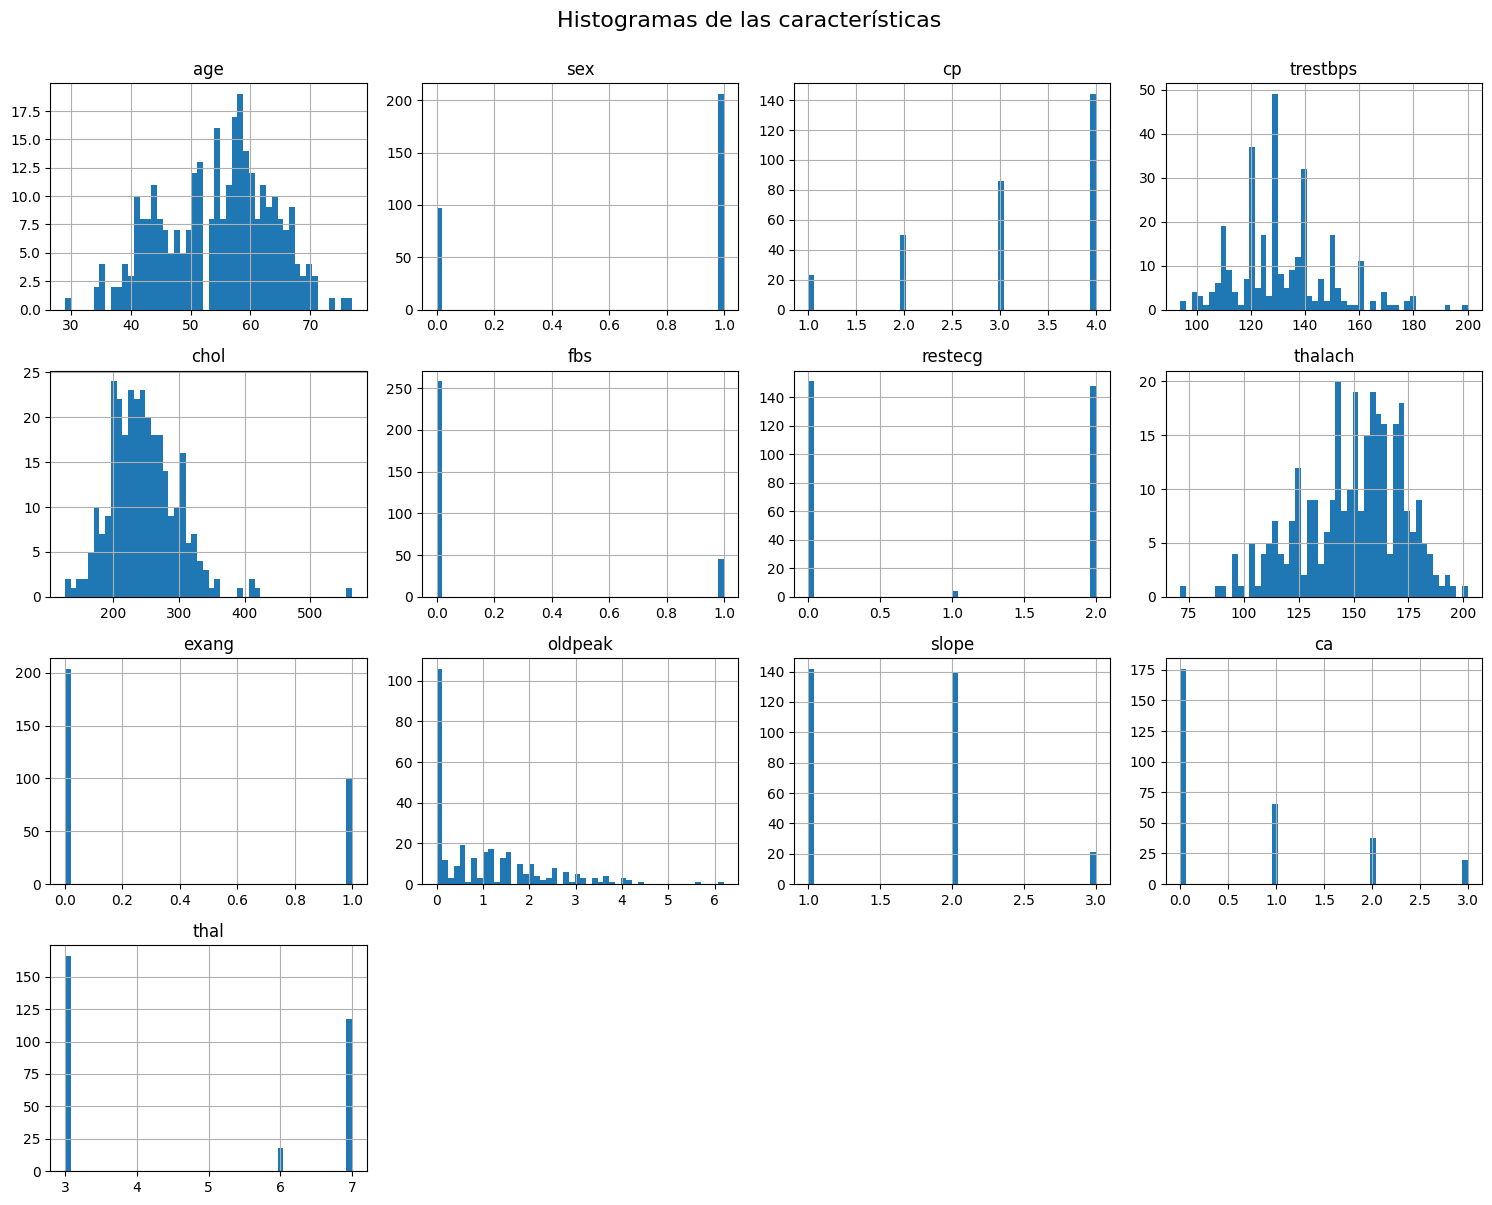

In [11]:
df[df.columns[:13]].hist(bins=50, figsize=(15, 12), layout=(4, 4))
plt.suptitle("Histogramas de las características", y=1, fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
df['num'].value_counts()

num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

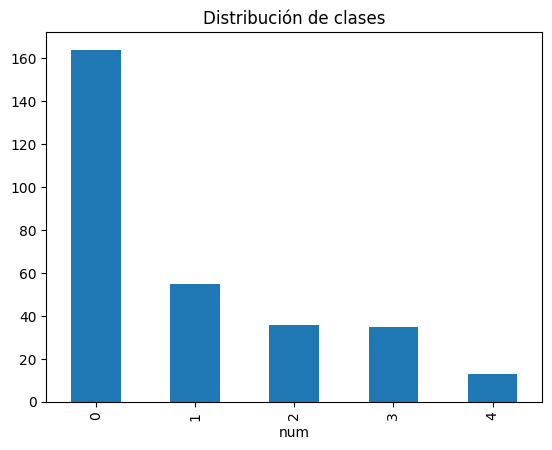

In [13]:
df['num'].value_counts().plot(kind='bar')
plt.title('Distribución de clases')
plt.show()

Transformaremos el problema en binario, considerando 0 como ausencia de enfermedad coronaria, y 1 como presencia de enfermedad. No solo para simplificar el problema (ya que es introductorio), sino para que las clases estén más balanceadas.

In [14]:
df_binary = df.copy()

In [15]:
df_binary['num'] = df_binary['num'].apply(lambda x: 1 if x>0 else 0)

In [16]:
df_binary['num'].value_counts() 

num
0    164
1    139
Name: count, dtype: int64

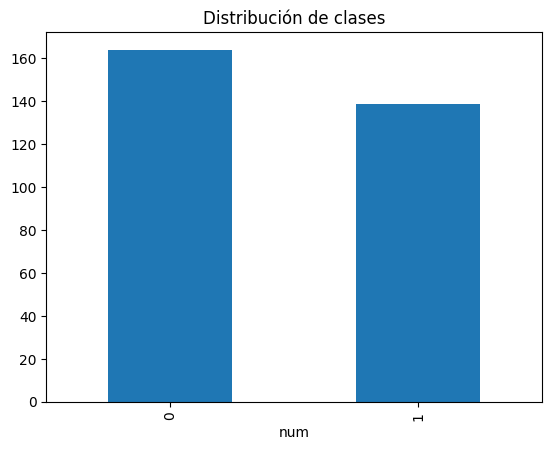

In [17]:
df_binary['num'].value_counts().plot(kind='bar')
plt.title('Distribución de clases')
plt.show()

Como podemos ver están mejor distribuidas.

Eliminaremos los registros con valores nulos ya que son muy pocos.

In [18]:
df_binary = df_binary.dropna()

In [19]:
X = df_binary[df_binary.columns[:13]]
Y = df_binary['num']

In [20]:
# Escalado de datos
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [21]:
# Convert DataFrame to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y.values, dtype=torch.float32)

Separamos en conjunto de entrenamiento y prueba

In [22]:
X_temp, X_test, Y_temp, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.05, random_state=42)

In [23]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

In [24]:
BATCH_SIZE = 1

In [25]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Arquitectura de la red Neuronal

In [26]:
print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

torch.Size([225, 13]) torch.Size([12, 13]) torch.Size([60, 13])
torch.Size([225]) torch.Size([12]) torch.Size([60])


In [27]:
input_size = X_train.shape[1]
hidden_size = 16
output_size = 1

In [28]:
input_size

13

In [29]:
# Construcción del modelo
class NonLinearModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NonLinearModel, self).__init__()
        self.dense1 = nn.Linear(input_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, 2*hidden_size)
        self.dense3 = nn.Linear(2*hidden_size, hidden_size)
        self.dense4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.relu(self.dense3(x))
        x = self.relu(self.dense4(x))
        x = self.sigmoid(x)
        return x

In [30]:
EPOCHS = 30
LR = 0.0001

In [31]:
model = NonLinearModel(input_size, hidden_size)
summary(model, (input_size,), batch_size=BATCH_SIZE, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [1, 16]             224
              ReLU-2                    [1, 16]               0
            Linear-3                    [1, 32]             544
              ReLU-4                    [1, 32]               0
            Linear-5                    [1, 16]             528
              ReLU-6                    [1, 16]               0
            Linear-7                     [1, 1]              17
              ReLU-8                     [1, 1]               0
           Sigmoid-9                     [1, 1]               0
Total params: 1,313
Trainable params: 1,313
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
-----------------------------------------------

In [32]:
cost = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [33]:
# Entrenamiento del modelo
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(EPOCHS):
    # Training phase
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = cost(outputs, labels.float().view(-1, 1))  # labels are 0 or 1

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        correct_predictions += (predictions == labels.float().view(-1, 1)).sum().item()
        total_samples += labels.size(0)

        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss = cost(val_outputs, val_labels.float().view(-1, 1))

            # Calculate accuracy
            val_predictions = (val_outputs > 0.5).float()
            correct_predictions += (val_predictions == val_labels.float().view(-1, 1)).sum().item()
            total_samples += val_labels.size(0)

            total_loss += val_loss.item()

    val_epoch_loss = total_loss / len(val_loader)
    val_epoch_accuracy = correct_predictions / total_samples

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.4f}')

Epoch 1/30, Train Loss: 0.6937, Train Acc: 0.4667, Val Loss: 0.6912, Val Acc: 0.7500
Epoch 2/30, Train Loss: 0.6930, Train Acc: 0.5022, Val Loss: 0.6908, Val Acc: 0.7500
Epoch 3/30, Train Loss: 0.6924, Train Acc: 0.5600, Val Loss: 0.6896, Val Acc: 0.7500
Epoch 4/30, Train Loss: 0.6919, Train Acc: 0.5022, Val Loss: 0.6895, Val Acc: 0.7500
Epoch 5/30, Train Loss: 0.6912, Train Acc: 0.5511, Val Loss: 0.6880, Val Acc: 0.7500
Epoch 6/30, Train Loss: 0.6903, Train Acc: 0.5378, Val Loss: 0.6867, Val Acc: 0.7500
Epoch 7/30, Train Loss: 0.6892, Train Acc: 0.5244, Val Loss: 0.6855, Val Acc: 0.7500
Epoch 8/30, Train Loss: 0.6877, Train Acc: 0.5689, Val Loss: 0.6825, Val Acc: 0.7500
Epoch 9/30, Train Loss: 0.6858, Train Acc: 0.5733, Val Loss: 0.6794, Val Acc: 0.7500
Epoch 10/30, Train Loss: 0.6833, Train Acc: 0.5511, Val Loss: 0.6762, Val Acc: 0.7500
Epoch 11/30, Train Loss: 0.6802, Train Acc: 0.6267, Val Loss: 0.6698, Val Acc: 0.7500
Epoch 12/30, Train Loss: 0.6765, Train Acc: 0.6267, Val Loss: 0

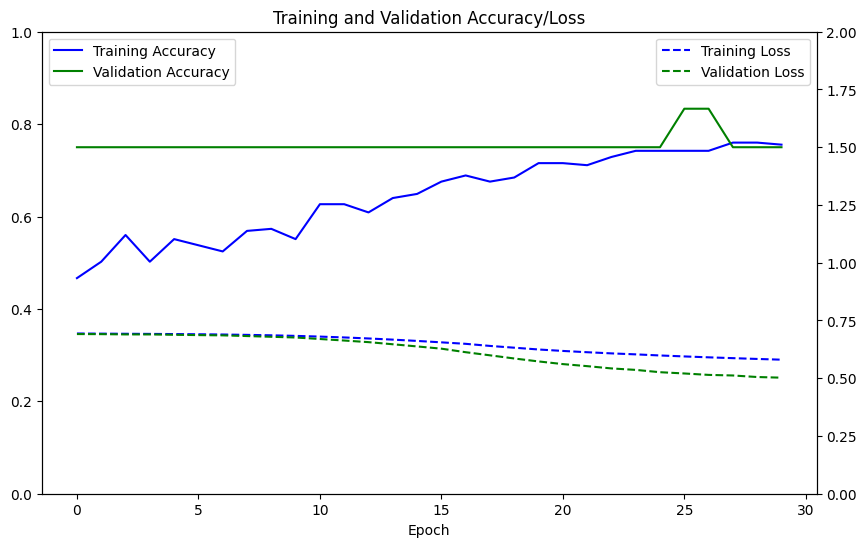

In [34]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting Accuracy on the primary y-axis
ax1.plot(train_accuracies, label='Training Accuracy', color='blue')
ax1.plot(val_accuracies, label='Validation Accuracy', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')

# Creating a secondary y-axis for Loss
ax2 = ax1.twinx()
ax2.plot(train_losses, label='Training Loss', color='blue', linestyle='--')
ax2.plot(val_losses, label='Validation Loss', color='green', linestyle='--')
ax2.legend(loc='upper right')
ax2.set_ylim(0, 2)

plt.title('Training and Validation Accuracy/Loss')
plt.show()

In [35]:
# Model evaluation on the test set
model.eval()
test_predictions = []

with torch.no_grad():
    for test_inputs in test_loader:  
        test_outputs = model(test_inputs[0])
        test_predictions.extend(test_outputs.cpu().numpy())

test_predictions = np.concatenate(test_predictions)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
threshold = 0.5
y_pred = (torch.tensor(test_predictions) > threshold).int()

In [36]:
prob_pos = [value if value > 0.5 else 0 for value in test_predictions]

In [37]:
# Classification Report
print("Classification Report:")
print(classification_report(Y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87        36
         1.0       0.76      0.92      0.83        24

    accuracy                           0.85        60
   macro avg       0.85      0.86      0.85        60
weighted avg       0.86      0.85      0.85        60



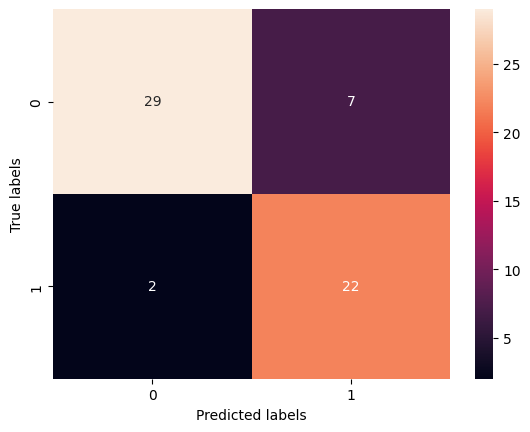

In [38]:
plot_confusion_matrix(Y_test, y_pred)

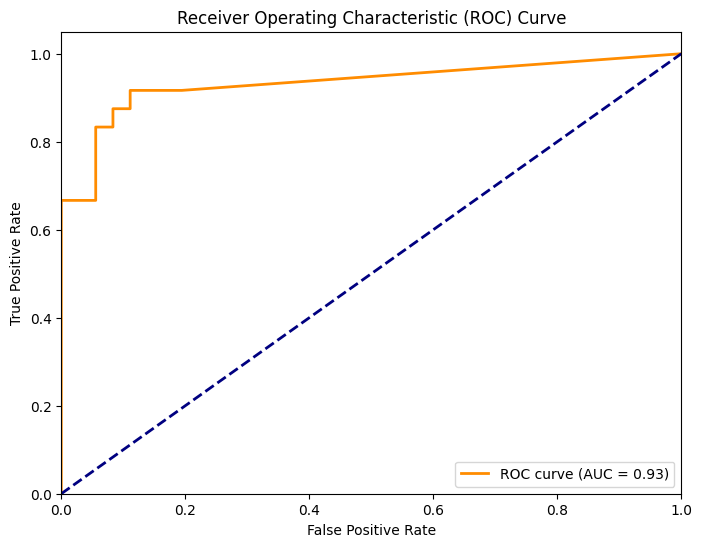

In [39]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, prob_pos) 
# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Ejercicios:

* Aceptarían este modelo? **Qué puede estar pasando si observan el gráfico de entrenamiento y validación?**

* Investigar sobre las funciones de activación (ReLU, Sigmoid, etc.). Conocer sus funcionalidades, fortalezas y debilidades. **Por qué las necesitamos en general?**

* Mejorar el modelo, si es posible. Explorar con diferentess optimizadores, batch sizes, capas, activaciones, pérdidas, etc. Manipular hiperparámetros para obtener mejores resultados. **Es necesario incluir todas las características en el modelo?**

* Por otro lado, la función **XOR** es linealmente separable?

Links de Referencia:

* Pytorch Docs: https://pytorch.org/

Links de interés:

* Neural Network PlayGround: https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.99698&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)